Facility Cost Analysis - National Heatmap
This notebook creates comprehensive heatmaps showing:
1. Total Facility Costs (Rent + Utilities)
2. Labor Costs
3. Combined Cost Index

# Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap
from branca.colormap import LinearColormap
%matplotlib inline

# Load and Prepare Data

In [3]:
# Load all datasets
demand_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data/demand.csv')
products_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data/products.csv') # pd.read_csv('Assignment Files/Data/products.csv')
stores_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//stores.csv')
rates_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//rates.csv')
labor_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//labor_cost.csv')
facilities_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//facilities.csv')


# Calculate total facility cost per square foot
facilities_df['Total_Cost_SqFt'] = facilities_df['RentCost_SqFt'] + facilities_df['UtilitiesOpsCost_SqFt']

# Create Cost Heatmap Function

In [4]:
def create_cost_heatmap(title, locations, values, save_name):
    """Create a folium map with cost heatmap"""
    m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
    
    # Create heatmap layer
    HeatMap(
        list(zip(
            [loc[0] for loc in locations],
            [loc[1] for loc in locations],
            values
        )),
        radius=35
    ).add_to(m)
    
    # Add title
    title_html = f'''
        <div style="position: fixed; 
                    top: 10px; 
                    left: 50px; 
                    width: 300px; 
                    height: 30px; 
                    z-index:9999; 
                    background-color: white; 
                    font-size: 16px; 
                    font-weight: bold;
                    padding: 5px;
                    border-radius: 5px;">
            {title}
        </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    return m

# Generate Facility Cost Heatmap

In [5]:
# Prepare facility cost data
facility_locations = []
facility_costs = []

for _, facility in facilities_df.iterrows():
    city = facility['Location'].split(',')[0].strip()
    state = facility['Location'].split(',')[1].strip()
    matching_stores = stores_df[
        (stores_df['City'] == city) & 
        (stores_df['State'] == state)
    ]
    
    if len(matching_stores) > 0:
        facility_locations.append([
            matching_stores.iloc[0]['Latitude'],
            matching_stores.iloc[0]['Longitude']
        ])
        facility_costs.append(facility['Total_Cost_SqFt'])

# Create facility cost heatmap
facility_cost_map = create_cost_heatmap(
    'Total Facility Cost per Square Foot ($)',
    facility_locations,
    facility_costs,
    'facility_cost_heatmap.html'
)
display(facility_cost_map)

# Generate Labor Cost Heatmap

In [6]:
# Prepare labor cost data
labor_locations = []
labor_costs = []

for _, labor in labor_df.iterrows():
    city = labor['Location'].split(',')[0].strip()
    state = labor['Location'].split(',')[1].strip()
    matching_stores = stores_df[
        (stores_df['City'] == city) & 
        (stores_df['State'] == state)
    ]
    
    if len(matching_stores) > 0:
        labor_locations.append([
            matching_stores.iloc[0]['Latitude'],
            matching_stores.iloc[0]['Longitude']
        ])
        labor_costs.append(labor['Local Labor Cost (USD/hour)'])

# Create labor cost heatmap
labor_cost_map = create_cost_heatmap(
    'Local Labor Cost ($/hour)',
    labor_locations,
    labor_costs,
    'labor_cost_heatmap.html'
)
display(labor_cost_map)

# Create Combined Cost Index Map

In [7]:
def normalize_values(values):
    """Normalize values to 0-1 range"""
    min_val = min(values)
    max_val = max(values)
    return [(v - min_val) / (max_val - min_val) for v in values]

def create_combined_cost_map():
    """Create a map showing combined cost index"""
    m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
    
    # Create state to labor cost mapping
    state_labor_costs = {}
    for _, row in labor_df.iterrows():
        state = row['Location'].split(',')[1].strip()
        if state not in state_labor_costs:
            state_labor_costs[state] = []
        state_labor_costs[state].append(row['Local Labor Cost (USD/hour)'])
    
    # Average labor costs for states with multiple cities
    state_labor_avg = {state: np.mean(costs) for state, costs in state_labor_costs.items()}
    
    # Process all facilities
    combined_data = []
    for _, facility in facilities_df.iterrows():
        state = facility['Location'].split(',')[1].strip()
        if state in state_labor_avg:
            facility_cost = facility['Total_Cost_SqFt']
            labor_cost = state_labor_avg[state]
            
            # Normalize both costs
            norm_facility = (facility_cost - min(facilities_df['Total_Cost_SqFt'])) / (max(facilities_df['Total_Cost_SqFt']) - min(facilities_df['Total_Cost_SqFt']))
            norm_labor = (labor_cost - min(labor_df['Local Labor Cost (USD/hour)'])) / (max(labor_df['Local Labor Cost (USD/hour)']) - min(labor_df['Local Labor Cost (USD/hour)']))
            
            # Calculate combined index
            combined_index = np.mean([norm_facility, norm_labor])
            
            # Get location coordinates
            matching_stores = stores_df[
                (stores_df['City'] == facility['Location'].split(',')[0].strip()) & 
                (stores_df['State'] == state)
            ]
            if len(matching_stores) > 0:
                lat = matching_stores.iloc[0]['Latitude']
                lon = matching_stores.iloc[0]['Longitude']
                
                combined_data.append({
                    'Location': facility['Location'],
                    'Combined_Index': combined_index,
                    'Facility_Cost': facility_cost,
                    'Labor_Cost': labor_cost,
                    'Latitude': lat,
                    'Longitude': lon
                })
                
                # Add marker
                folium.CircleMarker(
                    location=[lat, lon],
                    radius=8,
                    color='purple',
                    fill=True,
                    popup=f"Location: {facility['Location']}<br>" +
                          f"Combined Index: {combined_index:.3f}<br>" +
                          f"Facility Cost: ${facility_cost:.2f}/sqft<br>" +
                          f"Labor Cost: ${labor_cost:.2f}/hr",
                    fillOpacity=0.7
                ).add_to(m)
    
    # Create and sort DataFrame
    combined_df = pd.DataFrame(combined_data)
    combined_df = combined_df.sort_values('Combined_Index')
    
    # Add heatmap layer
    heat_data = [[row['Latitude'], row['Longitude'], row['Combined_Index']] 
                 for _, row in combined_df.iterrows()]
    HeatMap(heat_data, radius=35).add_to(m)
    
    return m, combined_df

In [8]:
# Create and display combined cost map and table
combined_map, combined_df = create_combined_cost_map()
pd.set_option('display.max_rows', 500)
print("\nCombined Cost Index Analysis (Sorted from Lowest to Highest):")
display(combined_df)
display(combined_map)


Combined Cost Index Analysis (Sorted from Lowest to Highest):


,Location,Combined_Index,Facility_Cost,Labor_Cost,Latitude,Longitude
10,"Houston, TX",0.111864,10.5,23.83125,29.751691,-95.362532
22,"San Antonio, TX",0.122567,11.2,23.83125,29.430470,-98.499354
46,"Dallas, TX",0.140916,12.4,23.83125,32.782881,-96.805675
5,"Austin, TX",0.142445,12.5,23.83125,30.267187,-97.742816
24,"Houston, TX",0.157735,13.5,23.83125,29.751691,-95.362532
48,"Dallas, TX",0.160793,13.7,23.83125,32.782881,-96.805675
56,"San Antonio, TX",0.162322,13.8,23.83125,29.430470,-98.499354
2,"Austin, TX",0.163851,13.9,23.83125,30.267187,-97.742816
1,"Memphis, TN",0.174689,10.1,25.65750,35.159309,-90.055075
23,"Memphis, TN",0.200682,11.8,25.65750,35.159309,-90.055075


# Cost Distribution Analysis

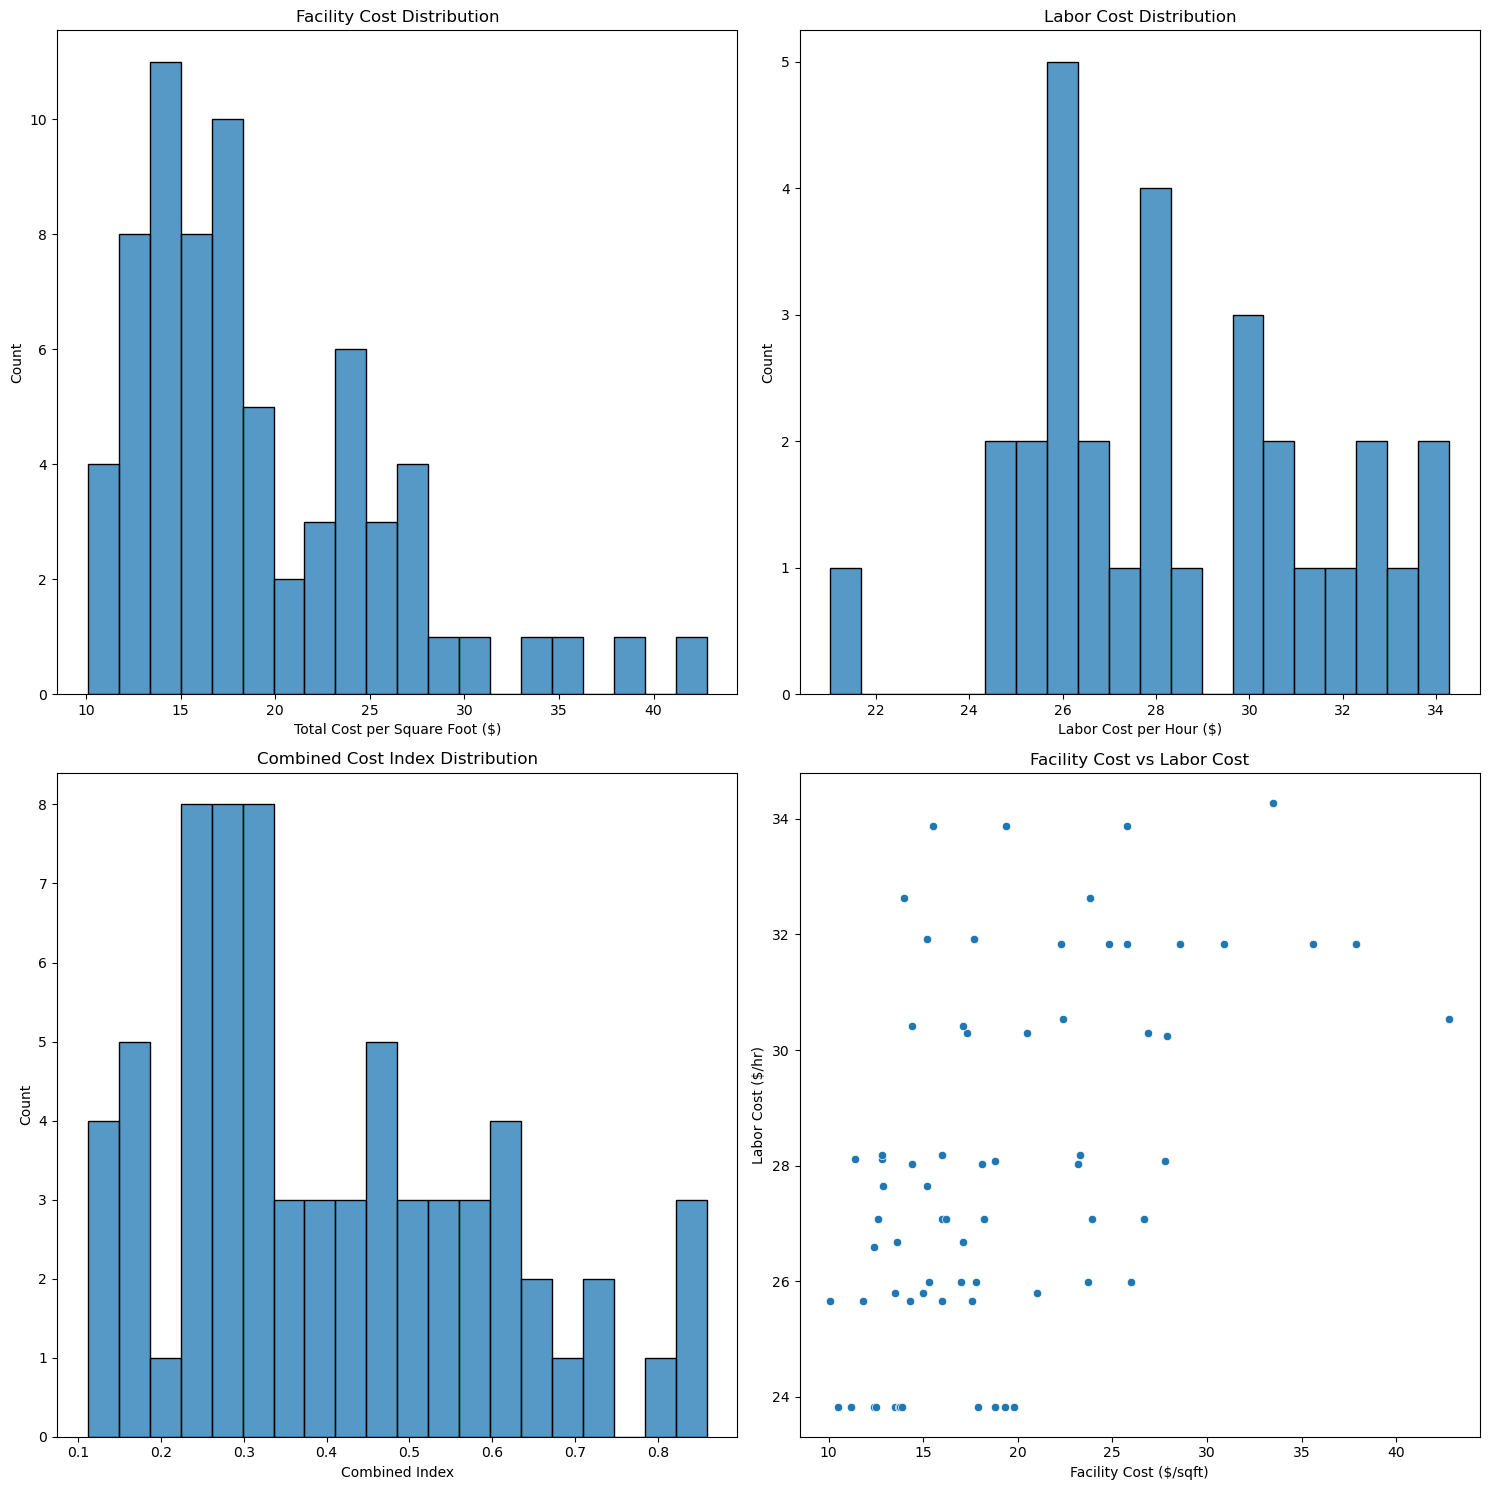

In [9]:
# Create distribution plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Facility Cost Distribution
sns.histplot(data=facilities_df, x='Total_Cost_SqFt', bins=20, ax=ax1)
ax1.set_title('Facility Cost Distribution')
ax1.set_xlabel('Total Cost per Square Foot ($)')
ax1.set_ylabel('Count')

# Labor Cost Distribution
sns.histplot(data=labor_df, x='Local Labor Cost (USD/hour)', bins=20, ax=ax2)
ax2.set_title('Labor Cost Distribution')
ax2.set_xlabel('Labor Cost per Hour ($)')
ax2.set_ylabel('Count')

# Combined Index Distribution
sns.histplot(data=combined_df, x='Combined_Index', bins=20, ax=ax3)
ax3.set_title('Combined Cost Index Distribution')
ax3.set_xlabel('Combined Index')
ax3.set_ylabel('Count')

# Facility vs Labor Cost Scatter
sns.scatterplot(data=combined_df, x='Facility_Cost', y='Labor_Cost', ax=ax4)
ax4.set_title('Facility Cost vs Labor Cost')
ax4.set_xlabel('Facility Cost ($/sqft)')
ax4.set_ylabel('Labor Cost ($/hr)')

plt.tight_layout()
plt.show()

# Key Findings

1. Facility Costs:
   - Highest in coastal areas (especially West Coast)
   - Lowest in central regions
   - Significant variation between urban and rural areas

2. Labor Costs:
   - Follow similar patterns to facility costs
   - Higher in major metropolitan areas
   - More uniform in central regions

3. Combined Cost Index:
   - Identifies optimal regions balancing both facility and labor costs
   - Shows clear cost advantages in certain geographic areas
   - Top 5 lowest-cost locations: {', '.join(combined_df.head(5)['Location'].tolist())}